#### Treatment Comparison
Compare barcoded subpopulations of idling and untreated (control) SKMEL5 cells by their cell-cell distance


In [1]:
# load files and packages
from fst_utils import *
from fcc_utils import *
from fcc_DRs import *
from utilityfunctions import *

%matplotlib inline

Using TensorFlow backend.


In [ ]:
# reload functions when editing file
import sys
del sys.modules['utilityfunctions']
from utilityfunctions import *

Read in data files and associate barcodes with RNA counts

In [2]:
%%time
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 31.7 s, sys: 5.16 s, total: 36.8 s
Wall time: 37.8 s


In [3]:
top20 = list(range(1,21))

Using top barcodes in __Untreated__ set, look at abundance in __Idling__ set

In [4]:
min(U.barcode_counts(IDs=U.top_barcodes(top20)))

28

In [5]:
min(I.barcode_counts(IDs=U.top_barcodes(top20)))

20

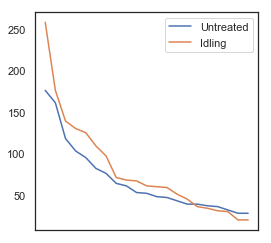

In [6]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(4,4))
U.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Untreated', legend=True)
I.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Idling', legend=True)
plt.show()

In [7]:
# get list of codes to use throughout the rest of analysis
selected_codes = U.top_barcodes(top20)

---
### PCA
100 component on arcsinh-transformed counts data

Perform PCA on each dataset and plot selected barcodes

In [8]:
%%time 
# perform PCA with 100 components on untreated cells, arcsinh-normalized
U_PCA = fcc_PCA(matrix=U.arcsinh_norm(), barcodes=U.barcodes, n_components=100)

CPU times: user 15.3 s, sys: 1.85 s, total: 17.2 s
Wall time: 11.4 s


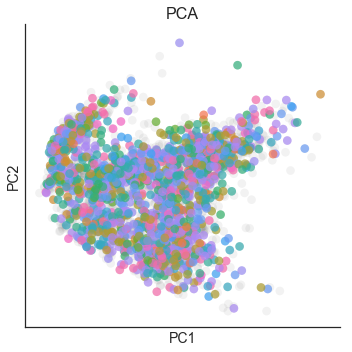

In [9]:
U_PCA.plot_barcodes(ranks=selected_codes)

In [10]:
%%time 
# perform PCA with 100 components on idling cells, arcsinh-normalized
I_PCA = fcc_PCA(matrix=I.arcsinh_norm(), barcodes=I.barcodes, n_components=100)

CPU times: user 16.3 s, sys: 2.7 s, total: 19 s
Wall time: 13.5 s


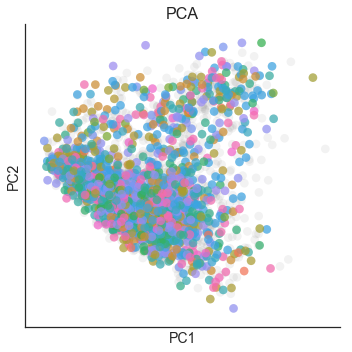

In [11]:
I_PCA.plot_barcodes(selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

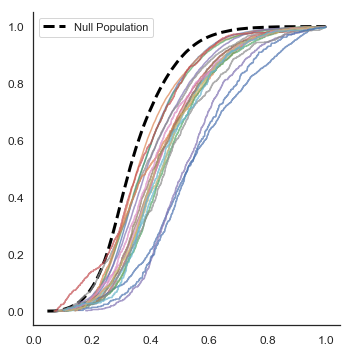

CPU times: user 34.1 s, sys: 1.41 s, total: 35.5 s
Wall time: 35.5 s


In [12]:
%%time
U_out = compare_barcode_distances(obj=U_PCA, barcodes=selected_codes)

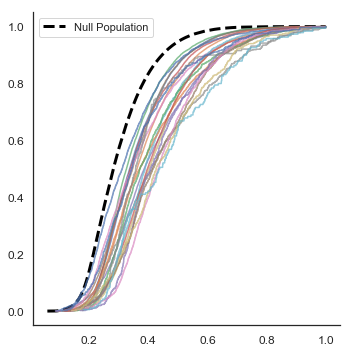

CPU times: user 52.2 s, sys: 2.6 s, total: 54.8 s
Wall time: 54.8 s


In [13]:
%%time
I_out = compare_barcode_distances(obj=I_PCA, barcodes=selected_codes)

---
Now, we want to generate statistical confidence in the "noise" or tolerance for EMD using random subsampling for calculation of EMD from the null population.

Need to correct for number of cells in each barcode, and bias in EMD compared to whole population. The acceptance criteria line should be fit to number of cells and have some growing uncertainty around it.

In [14]:
U.barcode_counts(selected_codes)

CTGAGTCAGAGTGACACACT    176
CTGAGAGTGAGTCTGTCAGT    161
CTGAGTCACTCACTGAGTGT    118
CTGAGTGTGAGAGTGTGTGT    103
CTGACAGTGTCACACAGTGA    95 
CTGAGAGACTCTGTGACTGA    82 
CTGAGACTCAGACAGACACT    76 
CTGACTGTCAGACAGAGTGA    64 
CTGAGTCAGTCACACTCTGT    61 
CTGACTGTCTGTCAGTGTGT    53 
CTGACAGTGTGTCAGTCTCT    52 
CTGAGAGTCACTGAGTGTGT    48 
CTGAGTGTCACTCTCTCAGA    47 
CTGACAGACACTCTCAGTCT    43 
CTGACAGTCACACTGACTCA    39 
CTGAGTGTGACTGTGTGTGA    39 
CTGACTGTGTGTCAGTGTGA    37 
CTGACTGAGAGTGAGTCACA    36 
CTGAGAGTGACAGACTCAGT    32 
CTGACACACTCTCACTGACA    28 
CTGACTCTGTCACAGAGTGA    28 
Name: Barcode, dtype: int64

In [16]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve = cell_bias_curve(obj=U_PCA, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 3min 57s, sys: 5.04 s, total: 4min 2s
Wall time: 4min 2s


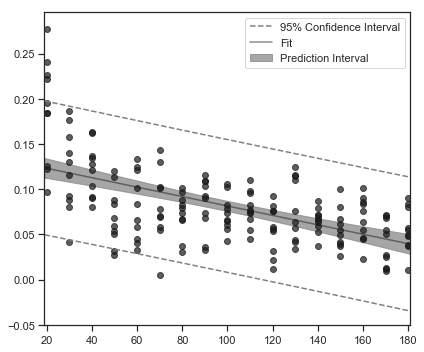

In [33]:
U_p, U_pi, U_ci = easy_regression(x=U_curve.melt(id_vars='n_cells')['n_cells'], y=U_curve.melt(id_vars='n_cells')['value'], deg=1)

---
Do the same as above for __Idling__ dataset

In [ ]:
I.barcode_counts(selected_codes)

In [18]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve = cell_bias_curve(obj=I_PCA, pop_sizes=np.arange(20, 261, 10), iter=10)

CPU times: user 9min 3s, sys: 16.4 s, total: 9min 19s
Wall time: 14min 37s


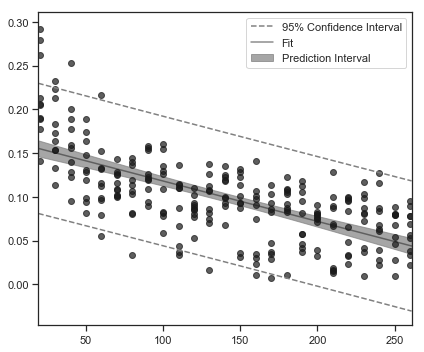

In [31]:
I_p, I_pi, I_ci = easy_regression(x=I_curve.melt(id_vars='n_cells')['n_cells'], y=I_curve.melt(id_vars='n_cells')['value'], deg=1)

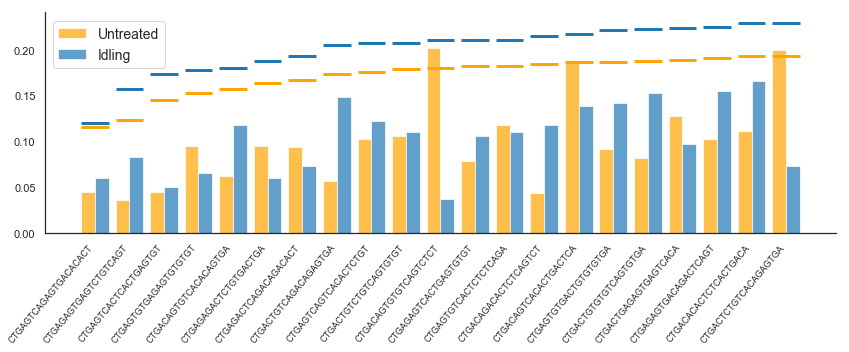

In [34]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc=[0.01,0.75],fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()


Look at 11th barcode - switch to significance in idling

In [ ]:
U_PCA.plot_barcodes(ranks=[selected_codes[10]])

In [ ]:
I_PCA.plot_barcodes(ranks=[selected_codes[10]])

Look at 8th barcode - significance in untreated control

---
### Feature Selection
Prime t-SNE with [NVR feature selection](https://github.com/KenLauLab/NVR)

In [ ]:
U_nvr = U.nvr_select(counts_obj=U)

In [ ]:
%%time 
U_nvr_PCA = fcc_PCA(matrix=U_nvr.counts, barcodes=U.barcodes, n_components=10)
U_nvr_PCA.plot()
U_nvr_PCA.plot_barcodes(selected_codes)

In [ ]:
%%time 
U_nvr_tSNE = fcc_FItSNE(matrix=U_nvr_PCA.results, barcodes=U_nvr_PCA.barcodes, perplexity=30)
U_nvr_tSNE.plot()
U_nvr_tSNE.plot_barcodes(selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

In [ ]:
%%time
pre = U_nvr_tSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

U_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = U_nvr_tSNE.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    U_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Untreated', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

U_out = pd.DataFrame(U_out)

In [ ]:
%%time 
# range of top 12 barcodes in untreated dataset is 40 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = U_nvr_tSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

U_baseline_curve = []
for rep in np.arange(1,11):
    U_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(40, 181, 10):
        U_rand = U_nvr_tSNE.results[np.random.choice(U_FItSNE.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(U_rand, U_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        U_EMD.append(EMD)
    
    if len(U_baseline_curve)==0:
        U_baseline_curve = pd.DataFrame({'n_cells':np.arange(40, 181, 10), 'EMD1':U_EMD})
        
    else:
        U_baseline_curve['EMD{}'.format(rep)] = U_EMD

In [ ]:
U_p, U_pi, U_ci = easy_regression(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_baseline_curve.melt(id_vars='n_cells')['value'], deg=2)

NVR doesn't do a great job with this dataset, let's try a brute-force variable genes selection

---
#### Feature Selection (Variable Genes)
NVR didn't seem to work very well

In [23]:
U_vg = U.var_select(counts_obj=U, n_features=200) # select 200 most variable genes

In [ ]:
compare_distance_dist(pre=U_vg.distance_matrix(transform='arcsinh', ranks='all'), post=U_vg.distance_matrix(transform='arcsinh', ranks=selected_codes[2]))

In [ ]:
%time U_vg_tSNE = fcc_FItSNE(matrix=U_vg.counts, barcodes=U_vg.barcodes, perplexity=30)

In [ ]:
U_vg_tSNE.plot() 
U_vg_tSNE.plot_barcodes(top20)

In [ ]:
%%time
pre = U_vg_tSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

U_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = U_vg_tSNE.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    U_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Untreated', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

U_out = pd.DataFrame(U_out)

In [ ]:
%%time 
# range of top 12 barcodes in untreated dataset is 40 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = U_vg_tSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

U_baseline_curve = []
for rep in np.arange(1,11):
    U_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(40, 181, 10):
        U_rand = U_vg_tSNE.results[np.random.choice(U_vg_tSNE.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(U_rand, U_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        U_EMD.append(EMD)
    
    if len(U_baseline_curve)==0:
        U_baseline_curve = pd.DataFrame({'n_cells':np.arange(40, 181, 10), 'EMD1':U_EMD})
        
    else:
        U_baseline_curve['EMD{}'.format(rep)] = U_EMD

In [ ]:
U_p, U_pi, U_ci = easy_regression(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_baseline_curve.melt(id_vars='n_cells')['value'], deg=2)

---
Do same thing for __Idling__ dataset

In [ ]:
I_vg = I.var_select(counts_obj=I, n_features=200) # select 200 most variable genes

In [ ]:
compare_distance_dist(pre=I_vg.distance_matrix(transform='arcsinh', ranks='all'), post=I_vg.distance_matrix(transform='arcsinh', ranks=selected_codes[2]))

In [ ]:
%time I_vg_tSNE = fcc_FItSNE(matrix=I_vg.counts, barcodes=I_vg.barcodes, perplexity=30)

In [ ]:
I_vg_tSNE.plot() 
I_vg_tSNE.plot_barcodes(top20)

In [ ]:
%%time
pre = I_vg_tSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

I_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = I_vg_tSNE.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    I_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Idling', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

I_out = pd.DataFrame(I_out)

In [ ]:
%%time 
# range of top 12 barcodes in untreated dataset is 40 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = I_vg_tSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

I_baseline_curve = []
for rep in np.arange(1,11):
    I_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(40, 181, 10):
        I_rand = I_vg_tSNE.results[np.random.choice(I_vg_tSNE.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(I_rand, I_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        I_EMD.append(EMD)
    
    if len(I_baseline_curve)==0:
        I_baseline_curve = pd.DataFrame({'n_cells':np.arange(40, 181, 10), 'EMD1':I_EMD})
        
    else:
        I_baseline_curve['EMD{}'.format(rep)] = I_EMD

In [ ]:
I_p, I_pi, I_ci = easy_regression(x=I_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_baseline_curve.melt(id_vars='n_cells')['value'], deg=2)

In [ ]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=-0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_baseline_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_baseline_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.title('Significant Distance - Feature Selected t-SNE')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
#### Feature Selection (Variable Genes) & PCA

In [ ]:
%%time 
U_vg_PCA = fcc_PCA(matrix=U_vg.counts, barcodes=U_vg.barcodes, n_components=45)
U_vg_PCA.plot()
U_vg_PCA.plot_barcodes(selected_codes)

In [ ]:
%time U_vg_PCAtSNE = fcc_FItSNE(matrix=U_vg_PCA.results, barcodes=U_vg_PCA.barcodes, perplexity=30)

In [ ]:
U_vg_PCAtSNE.plot() 
U_vg_PCAtSNE.plot_barcodes(selected_codes)

In [ ]:
%%time
pre = U_vg_PCAtSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

U_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = U_vg_PCAtSNE.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    U_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Untreated', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

U_out = pd.DataFrame(U_out)

In [ ]:
%%time 
# range of top 12 barcodes in untreated dataset is 40 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = U_vg_PCAtSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

U_baseline_curve = []
for rep in np.arange(1,11):
    U_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(40, 181, 10):
        U_rand = U_vg_PCAtSNE.results[np.random.choice(U_vg_PCAtSNE.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(U_rand, U_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        U_EMD.append(EMD)
    
    if len(U_baseline_curve)==0:
        U_baseline_curve = pd.DataFrame({'n_cells':np.arange(40, 181, 10), 'EMD1':U_EMD})
        
    else:
        U_baseline_curve['EMD{}'.format(rep)] = U_EMD

In [ ]:
U_p, U_pi, U_ci = easy_regression(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_baseline_curve.melt(id_vars='n_cells')['value'], deg=2)

---
Do same thing for __Idling__ dataset

In [ ]:
%%time 
I_vg_PCA = fcc_PCA(matrix=I_vg.counts, barcodes=I_vg.barcodes, n_components=45)
I_vg_PCA.plot()
I_vg_PCA.plot_barcodes(selected_codes)

In [ ]:
%time I_vg_PCAtSNE = fcc_FItSNE(matrix=I_vg_PCA.results, barcodes=I_vg_PCA.barcodes, perplexity=30)

In [ ]:
I_vg_PCAtSNE.plot() 
I_vg_PCAtSNE.plot_barcodes(selected_codes)

In [ ]:
%%time
pre = I_vg_PCAtSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

I_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = I_vg_PCAtSNE.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    I_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Idling', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

I_out = pd.DataFrame(I_out)

In [ ]:
%%time 
# range of top 12 barcodes in untreated dataset is 40 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = I_vg_PCAtSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

I_baseline_curve = []
for rep in np.arange(1,11):
    I_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(40, 181, 10):
        I_rand = I_vg_PCAtSNE.results[np.random.choice(I_vg_PCAtSNE.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(I_rand, I_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        I_EMD.append(EMD)
    
    if len(I_baseline_curve)==0:
        I_baseline_curve = pd.DataFrame({'n_cells':np.arange(40, 181, 10), 'EMD1':I_EMD})
        
    else:
        I_baseline_curve['EMD{}'.format(rep)] = I_EMD

In [ ]:
I_p, I_pi, I_ci = easy_regression(x=I_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_baseline_curve.melt(id_vars='n_cells')['value'], deg=2)

In [ ]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=-0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_baseline_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_baseline_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.title('Significant Distance - Feature Selected, PCA primed t-SNE')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()